# Determining the cost of cars

Service for the sale of used cars "XXX" is developing an application to attract new customers. You can quickly find out the market value of your car. We have historical data at our disposal: technical characteristics, configurations and prices of cars. I need to build a model to determine the cost.

The customer is important:

- quality of prediction;
- prediction speed;
- studying time.

## Data preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import time
import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoost
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import mean_squared_error, make_scorer

%matplotlib inline

In [ ]:
df = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
df.columns = df.columns.str.lower()

In [ ]:
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [ ]:
display(df.info())
display(df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
datecrawled          354369 non-null datetime64[ns]
price                354369 non-null int64
vehicletype          316879 non-null object
registrationyear     354369 non-null int64
gearbox              334536 non-null object
power                354369 non-null int64
model                334664 non-null object
kilometer            354369 non-null int64
registrationmonth    354369 non-null int64
fueltype             321474 non-null object
brand                354369 non-null object
notrepaired          283215 non-null object
datecreated          354369 non-null datetime64[ns]
numberofpictures     354369 non-null int64
postalcode           354369 non-null int64
lastseen             354369 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 43.3+ MB


None

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registrationyear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
registrationmonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
numberofpictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postalcode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


At this stage, the presence of outliers in the features **registrationyear** (0 and 9999) and **power** (0 and 20.000 hp) can be accurately determined.

To be done:
- check gaps, fill in or delete
- calculate the age of the car at the time of the creation of the questionnaire (the date of the creation of the questionnaire minus the date of registration)
- remove redundant features
- identify anomalies
- change data types
- check for duplicates

### Filling gaps

In [ ]:
df.isna().sum()

datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
kilometer                0
registrationmonth        0
fueltype             32895
brand                    0
notrepaired          71154
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

For each feature, we will individually process the gaps further.

***Vehicletype***

In [ ]:
df['vehicletype'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicletype, dtype: int64

In [ ]:
display(df[df['vehicletype'] == 'other'].sample(3))
display(df[df['vehicletype'].isna()].sample(3))

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
55773,2016-03-19 07:54:41,1000,other,1999,manual,110,golf,150000,5,gasoline,volkswagen,no,2016-03-19,0,16515,2016-03-21 12:17:18
221876,2016-04-03 11:40:10,1000,other,1999,manual,101,a3,150000,11,petrol,audi,NaN,2016-04-03,0,96114,2016-04-07 12:44:48
295085,2016-03-29 20:58:56,3000,other,2002,manual,16,zafira,5000,7,petrol,opel,no,2016-03-29,0,55543,2016-04-06 07:17:28


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
232478,2016-03-13 11:43:10,1400,NaN,2016,manual,55,golf,150000,3,petrol,volkswagen,NaN,2016-03-13,0,52062,2016-03-17 13:15:28
320195,2016-03-06 01:43:32,5500,NaN,2017,manual,140,golf,150000,10,gasoline,volkswagen,no,2016-01-29,0,14943,2016-03-28 14:45:05
101847,2016-04-04 18:51:15,200,NaN,2000,NaN,0,punto,150000,0,NaN,fiat,NaN,2016-04-04,0,73095,2016-04-04 18:51:15


As can be seen from the data, the "other" car type includes not only undefined cars, but also quite understandable ones, for example, VW Golf, Transporter, Caddy.
The same thing with missing data on this feature.
Therefore, all missing values here will be replaced by "other".

In [ ]:
df['vehicletype'] = df['vehicletype'].fillna('other')

***Gearbox***

In [ ]:
df['gearbox'].value_counts()

manual    268251
auto       66285
Name: gearbox, dtype: int64

We cannot replace missing gearbox values with one of the known values. Therefore, I propose to leave the gaps as they are, just replace them with "other" so that some models do not swear.

In [ ]:
df['gearbox'] = df['gearbox'].fillna('other')

***Model***

There are a lot of car models, I definitely can’t replace one with one. There was an idea to check that the models were skipped for some specific brand, and then think about it.

In [ ]:
df['brand'][df['model'].isna()].value_counts()

volkswagen        3505
sonstige_autos    3374
bmw               1935
opel              1871
audi              1283
mercedes_benz     1210
ford              1013
peugeot            891
renault            735
fiat               502
mazda              352
smart              268
citroen            249
seat               235
hyundai            228
nissan             207
mitsubishi         160
toyota             157
honda              155
skoda              141
suzuki             137
alfa_romeo         137
kia                113
chevrolet          110
volvo              109
trabant             95
chrysler            89
rover               82
mini                62
daewoo              46
subaru              44
porsche             42
daihatsu            39
jeep                26
lancia              23
dacia               22
saab                16
lada                15
jaguar              14
land_rover          13
Name: brand, dtype: int64

An interesting result is that we have many cars without a specific brand (**sonstige_autos**). At the same time, gaps in models do not depend on the brand. Therefore, we change them to "other".

In [ ]:
df['model'] = df['model'].fillna('other')

***Fueltype***

In [ ]:
df['fueltype'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fueltype, dtype: int64

In [ ]:
display(df[(df['fueltype'] == 'other') & (df['model'] != 'other')].sample(3))
display(df[df['fueltype'].isna()].sample(3))

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
81717,2016-03-31 13:06:18,2990,wagon,1988,manual,0,601,60000,9,other,trabant,no,2016-03-31,0,64546,2016-04-05 22:45:52
28054,2016-03-27 18:39:14,1050,small,1984,manual,20,601,100000,1,other,trabant,no,2016-03-27,0,56751,2016-04-05 14:47:44
363,2016-03-14 23:52:32,6500,sedan,2007,manual,125,focus,125000,9,other,ford,no,2016-03-14,0,97199,2016-04-05 11:51:03


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
242639,2016-03-16 07:55:13,2030,other,2016,other,0,corsa,125000,0,NaN,opel,NaN,2016-03-16,0,22303,2016-03-19 06:45:59
147392,2016-03-14 08:55:18,899,other,1995,manual,55,other,150000,1,NaN,mercedes_benz,NaN,2016-03-14,0,99631,2016-04-07 08:45:18
318874,2016-04-04 19:42:16,7200,small,2009,manual,75,one,80000,0,NaN,mini,yes,2016-04-04,0,97453,2016-04-06 21:45:38


With the type of fuel, the same thing turned out as with the type of body: the values "other" can be for all models. Therefore, we will replace all gaps with the value "other".

In [ ]:
df['fueltype'] = df['fueltype'].fillna('other')

***Notrepaired***

In [ ]:
df['notrepaired'].value_counts()

no     247161
yes     36054
Name: notrepaired, dtype: int64

In [ ]:
df['notrepaired'] = df['notrepaired'].fillna('na')

It is not logical to replace more than 70 gaps passes with "yes" or "no". So let's replace it with NA.

### Cars' age

The age of the car will be calculated in years as the difference between the date the profile was created (DateCreated) and the year the car was registered (RegistrationYear).

### Removing features and duplicates

Now I can remove all signs that cannot affect the price of the car.

In [ ]:
"""
DESCRIPTION OF FEATURES TO BE REMOVED

DateCrawled - date of downloading the questionnaire from the database
DateCreated - date of creation of the questionnaire
RegistrationMonth - month of car registration
NumberOfPictures - the number of photos of the car
PostalCode - postal code of the owner of the profile (user)
LastSeen - the date of the user's last activity - there was an idea that this is the date the car was sold, but all the values ​​are there
                                                     dated 2016, so you can delete.
"""

df = df.drop(['datecrawled', 'datecreated', 'registrationmonth', 'postalcode', 'numberofpictures', 'lastseen'], axis=1)

Deleting duplicates

In [ ]:
df.duplicated().sum()

45191

In [ ]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,na
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,na
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
309173,0,other,2005,manual,0,colt,150000,petrol,mitsubishi,yes
309174,2200,other,2005,other,0,other,20000,other,sonstige_autos,na
309175,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
309176,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


### Anomaly detection

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,309178.0,4487.898495,4565.099808,0.0,1100.0,2800.0,6500.0,20000.0
registrationyear,309178.0,2004.362875,92.563413,1000.0,1999.0,2003.0,2008.0,9999.0
power,309178.0,110.996976,201.009413,0.0,69.0,105.0,143.0,20000.0
kilometer,309178.0,127221.131516,38526.706414,5000.0,125000.0,150000.0,150000.0,150000.0


***Price anomalies***

Estimated distribution of the target attribute price.

In [ ]:
def distribution_plot(feature, nbins=100):
    fig, ax = plt.subplots(figsize=(14,4))
    fig = sns.distplot(df[feature], bins=nbins).set_title(f'Target Feature Distribution {feature}')
    ax.set(xlabel='feature', ylabel='%')

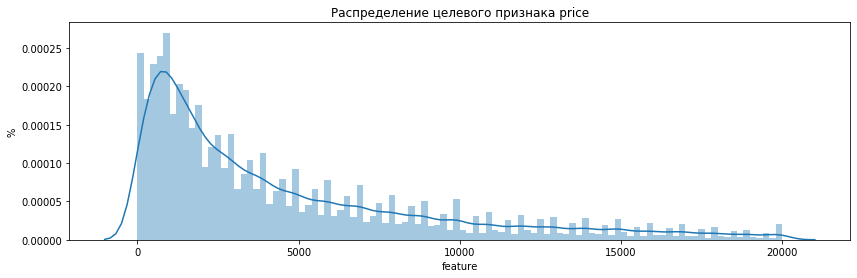

In [ ]:
distribution_plot('price')

Delete all rows where the price is less than 5.

In [ ]:
df = df.drop(df.query('price < 5').index).reset_index(drop=True)

***RegistrationYear anomalies***

Delete lines where the year of registration is earlier than 1900 or later than 2021.

In [ ]:
df = df.drop(df[(df['registrationyear'] > 2021) | (df['registrationyear'] < 1900)].index).reset_index(drop=True)

***Power anomalies***

Filling zero **Power** values with median values for a particular model.

In [ ]:
power_spectrum = df.query('power !=0').pivot_table(index=['brand','model','vehicletype'],values='power',aggfunc='median')

In [ ]:
def power(row):
    power = row['power'] 
    brand = row['brand']
    model = row['model']
    body = row['vehicletype']
    new_power = power
    if power == 0:
        try:
            new_power = power_spectrum.loc[(brand, model, body)].iloc[0]
        except:
            new_power = 0
    return new_power

In [ ]:
df['power'] = df.apply(power, axis = 1)

Let's look at the current distribution of the feature.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe62ff14b10>]],
      dtype=object)

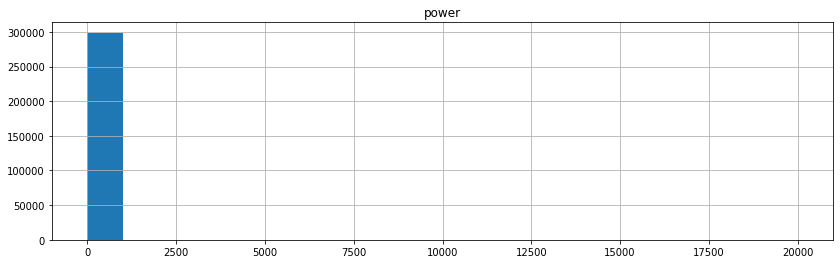

In [ ]:
df.hist('power', bins=20, figsize=(14, 4))

Let's look at objects that have a power of more than 400 hp. and sort by price. The more powerful the car, the more expensive.

In [ ]:
df.query('power > 400').sort_values(by='price', ascending=False).head(30)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
298856,20000,coupe,2006,auto,476.0,other,125000,petrol,mercedes_benz,no
174031,20000,sedan,2006,manual,420.0,other,150000,petrol,audi,no
126351,20000,sedan,2008,auto,408.0,7er,100000,petrol,bmw,no
30891,20000,sedan,2003,auto,500.0,s_klasse,80000,petrol,mercedes_benz,no
130856,20000,sedan,2007,auto,450.0,other,150000,petrol,audi,no
24390,20000,sedan,2006,auto,507.0,m_reihe,150000,petrol,bmw,no
239691,20000,wagon,2004,auto,450.0,other,150000,petrol,audi,no
292853,20000,other,2016,auto,507.0,m_reihe,150000,other,bmw,na
183961,19999,coupe,2007,auto,514.0,other,150000,petrol,mercedes_benz,no
214173,19999,wagon,2007,auto,435.0,other,125000,petrol,audi,no


The maximum power close to reality is 550 hp.
Delete all objects where Power is greater than 550 or less than 20 (there are not so many values and they are rather erroneous.)

In [ ]:
df = df.drop(df.query('power > 550 | power < 20').index).reset_index(drop=True)

Let's change the type of values to int, because now it's a float.

In [ ]:
df['power'] = df['power'].astype('int')

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,298289.0,4639.397507,4566.138102,5.0,1200.0,2950.0,6700.0,20000.0
registrationyear,298289.0,2003.262014,7.494957,1910.0,1999.0,2003.0,2008.0,2019.0
power,298289.0,119.303055,52.788740,20.0,75.0,110.0,145.0,550.0
kilometer,298289.0,127490.939994,37949.995956,5000.0,125000.0,150000.0,150000.0,150000.0


**CONCLUSION**

Data prepared for further work:
  - Missing values replaced
  - Duplicates removed
  - Anomalies removed
  - Extra signs removed

## Model training

In this section, we will train models without hyperparameter fitting.

### Preparing splits

I will first copy the dataset for training linear regression, in it we will not set the data type to **category**.

In [ ]:
df_non_cat = df.copy()

Selecting categorical features, change the data type to **category**, form samples for the CatBoost and LightGBM models.

In [ ]:
cat_columns = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']
num_columns = list(df.describe().columns)

In [ ]:
df[cat_columns] = df[cat_columns].astype('category')

In [ ]:
cat_features = df.drop(['price'], axis=1)
cat_target = df['price']

In [ ]:
Xcat_train, Xcat_test, ycat_train, ycat_test = train_test_split(cat_features, cat_target, test_size=0.25, random_state=42)

__________

Encode categorical features for working with linear regression.

In [ ]:
encoder = OrdinalEncoder()
df_non_cat_encoded = pd.DataFrame(encoder.fit_transform(df_non_cat[cat_columns]))
df_non_cat = df_non_cat.join(df_non_cat_encoded).drop(cat_columns, axis=1)

Making splits for working with linear regression (without changing the data type).

In [ ]:
features = df_non_cat.drop(['price'], axis=1)
target = df_non_cat['price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
rmse_score = make_scorer(rmse, greater_is_better = False)

### LinearRegression

In [ ]:
lr_model = LinearRegression()

In [ ]:
%%time
lr_model.fit(X_train, y_train)

CPU times: user 63.7 ms, sys: 4.1 ms, total: 67.8 ms
Wall time: 61.2 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
%%time
rmse(lr_model.predict(X_test), y_test)

CPU times: user 31.7 ms, sys: 51.7 ms, total: 83.5 ms
Wall time: 60.7 ms


3151.8817242509135

**LinearRegression**

**RMSE: 3151**

**TIME: ~71 ms (fit) + 30 ms (predict)**

### CatBoost

**CatBoost**

**RMSE: 1723**

**TIME: 12 min (fit) + 1 s (predict)**

### LightGBM

**LightGBM**

**RMSE: 1690**

**TIME: 12 min (fit) + 1 s (predict)**

### Conclusion

The best solution out of the box was shown by the LightGBM model.

## Analysis of models

Let's select the parameters for the models.

### CatBoost

Подбор параметром сделаем через GridSearchCV и RandomizedSearchCV.

The best RMSE result was **1813**.

Next, run RandomizedSearchCV.

The RMSE result of the model on the best parameters was **1706**, these parameters will be used further.

In [ ]:
best_params = {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 700, 'depth': 7}
catboost_model = CatBoostRegressor(**best_params, cat_features=cat_columns) 

In [ ]:
%%time
catboost_model.fit(Xcat_train, ycat_train, verbose=200)

0:	learn: 4416.3982526	total: 1.13s	remaining: 13m 9s
200:	learn: 1777.3367360	total: 3m 10s	remaining: 7m 53s
400:	learn: 1704.7614542	total: 6m 22s	remaining: 4m 45s
600:	learn: 1671.5790784	total: 9m 35s	remaining: 1m 34s
699:	learn: 1658.8054960	total: 11m 12s	remaining: 0us
CPU times: user 9min 58s, sys: 1min 15s, total: 11min 14s
Wall time: 11min 17s


**CatBoost**

**RMSE: 1802**

**TIME: 8 min (fit) + 1 s (predict)**

Let's build a graph of significant features for the current model.

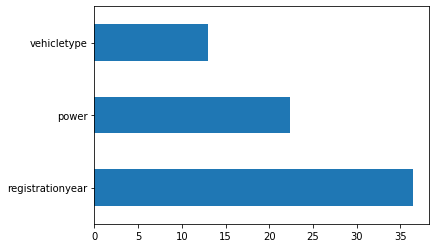

In [ ]:
pd.Series(catboost_model.feature_importances_, index=Xcat_train.columns).nlargest(3).plot(kind='barh')

### LightGBM

Let's train the LightGBM model on random parameters.

In [ ]:
lgbm_model = lgb.LGBMRegressor(learning_rate=0.2, num_leaves=5, max_depth=700, categorical_feature=cat_columns)

In [ ]:
%%time
lgbm_model.fit(Xcat_train, ycat_train)    

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:842: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:863: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


CPU times: user 17.5 s, sys: 78.1 ms, total: 17.5 s
Wall time: 17.9 s


LGBMRegressor(boosting_type='gbdt',
              categorical_feature=['vehicletype', 'gearbox', 'model',
                                   'fueltype', 'brand', 'notrepaired'],
              class_weight=None, colsample_bytree=1.0, importance_type='split',
              learning_rate=0.2, max_depth=700, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=5, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

**LightGBM**

**RMSE: 1825**

**TIME: 3 s (fit) + 340 ms (predict)**

Let's build a graph of significant features for the current model.

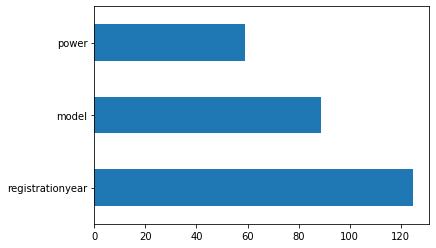

In [ ]:
pd.Series(lgbm_model.feature_importances_, index=Xcat_train.columns).nlargest(3).plot(kind='barh')

In [ ]:
# Сводим результаты в итоговую таблицу
cols = pd.MultiIndex.from_arrays([['Before Tuning', 'Before Tuning', 'After Tuning', 'After Tuning'],
                                ['RMSE', 'TIME (fit + pred), s', 'RMSE', 'TIME (fit + pred), s']])
data = [
        [3151, 101, None, None],
        [1723, 721, 1802, 481],
        [1690, 721, 1825, 180]]

results = pd.DataFrame(data=data, columns=cols, index=[['LinReg', 'CatBoost', 'LGBM']])


### Вывод

In [ ]:
results

Before Tuning                      After Tuning                     
                  RMSE TIME (fit + pred), s         RMSE TIME (fit + pred), s
LinReg            3151                  101          NaN                  NaN
CatBoost          1723                  721       1802.0                481.0
LGBM              1690                  721       1825.0                180.0

***Metrics***

According to the results of testing three models on standard parameters and selected ones, the best result was shown by the LightGBM RMSE: 1690, TIME: 12 min (fit) + 1 s (predict) model.


***Importance of features:***

Both models identified the vehicle registration year as the most important feature. CatBoost considered power as the next most important attribute, and LGBM - model, which in my opinion is more rational.